<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/master/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [0]:
import os
import logging
import sys

In [0]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 726 (delta 120), reused 0 (delta 0), pack-reused 532
Receiving objects: 100% (726/726), 467.43 KiB | 547.00 KiB/s, done.
Resolving deltas: 100% (449/449), done.


# Import packages

In [0]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np

from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

# Define Network

In [0]:
resNet = ResNet.resnet32(num_classes=100)
resNet = resNet.to(params.DEVICE)

In [0]:

train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define DataSets

In [0]:
trainDS = Dataset(train=True, transform = train_transformer)
testDS = Dataset(train=False, transform = test_transformer)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [0]:
train_splits = trainDS.splits
test_splits = testDS.splits
print(train_splits)
print(test_splits)

[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0], [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0], [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0], [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0], [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0], [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0], [57.0, 81.0, 12.0, 95.0, 25.0, 47.0, 34.0, 52.0, 44.0, 72.0], [46.0, 79.0, 20.0, 28.0, 5.0, 71.0, 8.0, 18.0, 33.0, 15.0], [55.0, 29.0, 64.0, 31.0, 67.0, 7.0, 13.0, 14.0, 42.0, 6.0], [82.0, 2.0, 27.0, 16.0, 26.0, 3.0, 4.0, 1.0, 9.0, 0.0]]
[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0], [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0], [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0], [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0], [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0], [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0], [57.0, 81.0, 12.

# Useful plots

In [0]:
def plotTask(pars_tasks):
  import numpy as np
  import matplotlib.pyplot as plt

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy', 'Loss'])
  plt.xlabel("Epoch")
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy', 'Loss'])
  plt.grid(True)
  plt.show()

In [0]:
def mapFunction(labels, splits):
	m_l = []
	l_splits = list(splits)
	for el in labels:
		m_l.append( l_splits.index(el) )
	return torch.LongTensor(m_l).to(params.DEVICE)

# Train and evaluation phase

In [0]:
pars_tasks = []
test_indexes = []

for task in range(0, 100, params.TASK_SIZE):
  pars_tasks.insert(task, 0)


optimizer = torch.optim.SGD(resNet.parameters(), lr=params.LR, momentum=params.MOMENTUM, weight_decay=params.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, params.STEP_SIZE, gamma=params.GAMMA) #allow to change the LR at predefined epochs
criterion = torch.nn.BCEWithLogitsLoss()

current_step = 0


for task in range(0, 100, params.TASK_SIZE):

  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes)
  test_dataset = Subset(testDS, test_indexes)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True )
  
  col = np.array(train_splits[int(task/10)]).astype(int)
  
  for epoch in range(params.NUM_EPOCHS):
    lenght = 0
    scheduler.step() #update the learning rate
    running_corrects = 0    
    for images, labels, _ in train_loader:
      images = images.float().to(params.DEVICE)
      labels = labels.to(params.DEVICE)
      mappedLabels = mapFunction(labels, col)   
      onehot_labels = torch.eye(100)[labels].to(params.DEVICE)#it creates the one-hot-encoding list for the labels; needed for BCELoss    
      optimizer.zero_grad() # Zero-ing the gradients
      outputs = resNet(images)
      loss = criterion(outputs,onehot_labels)   
      cut_outputs = np.take_along_axis(outputs.to(params.DEVICE), col[None, :], axis = 1).to(params.DEVICE)
      _, preds = torch.max(cut_outputs.data, 1)
      running_corrects += torch.sum(preds == mappedLabels.data).data.item()   
      loss.backward()   
      optimizer.step()    
      current_step += 1
      lenght += len(images)   
    accuracy = running_corrects / float(lenght)
    print("At step ", str(task), " and at epoch = ", epoch, " the loss is = ", loss.item(), " and accuracy is = ", accuracy)
  
  resNet = resNet.eval()

  t_l = 0
  running_corrects = 0
  col = []
  for i,x in enumerate( test_splits[ :int(task/10) + 1]):
  	v = np.array(x)
  	col = np.concatenate( (col,v), axis = None)
  col = col.astype(int)

  for images, labels, _ in test_loader:
    images = images.float().to(params.DEVICE)
    labels = labels.to(params.DEVICE)   
    mappedLabels = mapFunction(labels, col)

    onehot_labels = torch.eye(100)[labels].to(params.DEVICE)

    outputs = resNet(images).to(params.DEVICE)
    cut_outputs = np.take_along_axis(outputs, col[None, :], axis = 1)
    cut_outputs = cut_outputs.to(params.DEVICE)
    _, preds = torch.max(cut_outputs.data, 1)
		# Update Corrects
    running_corrects += torch.sum(preds == mappedLabels.data).data.item()
    print(len(images))
    t_l += len(images)
  # Calculate Accuracy
  accuracy = running_corrects / float(t_l)
  loss = criterion(outputs,onehot_labels)
  print('Validation Loss: {} Validation Accuracy : {}'.format(loss.item(),accuracy) )
  pars_tasks[int(task/10)] = (accuracy, loss.item())
  resNet = resNet.train(True)
  


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


At step  0  and at epoch =  0  the loss is =  0.03383159637451172  and accuracy is =  0.1828
At step  0  and at epoch =  1  the loss is =  0.03398982435464859  and accuracy is =  0.405
At step  0  and at epoch =  2  the loss is =  0.021684983745217323  and accuracy is =  0.4906
At step  0  and at epoch =  3  the loss is =  0.01981181651353836  and accuracy is =  0.5746
At step  0  and at epoch =  4  the loss is =  0.01945577561855316  and accuracy is =  0.6316
At step  0  and at epoch =  5  the loss is =  0.011442254297435284  and accuracy is =  0.6778
At step  0  and at epoch =  6  the loss is =  0.010256149806082249  and accuracy is =  0.7132
At step  0  and at epoch =  7  the loss is =  0.030698062852025032  and accuracy is =  0.7704
At step  0  and at epoch =  8  the loss is =  0.011082748882472515  and accuracy is =  0.778
At step  0  and at epoch =  9  the loss is =  0.0066450051963329315  and accuracy is =  0.7794
At step  0  and at epoch =  10  the loss is =  0.0178435333073139

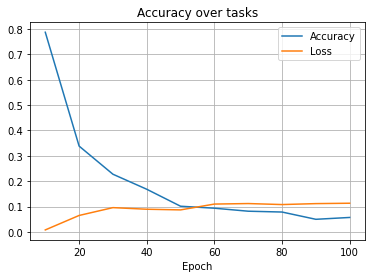

In [0]:
plotTask(pars_tasks)